In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier, RandomForestClassifier

Import Data

In [2]:
data = pd.read_csv('/content/loan_data_2007_2014.csv')

Define Target and Features

In [ ]:
# Split the loans into 2 categories, 'good loan' and 'bad loan'
good_loans = ['Current', 'Fully Paid', 'In Grace Period', 'Does not meet the credit policy. Status:Fully Paid']
bad_loans  = ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default', 'Does not meet the credit policy. Status:Charged Off']
data['good_bad_loan'] = np.where(data['loan_status'].isin(bad_loans), 1, 0)
data = data.drop(columns = ['loan_status'])
data = data.drop('Unnamed: 0', axis = 1)

In [ ]:
X = data.drop(columns = 'good_bad_loan', axis = 1)
y = data['good_bad_loan']

In [ ]:
data['good_bad_loan'].value_counts()

0    414099
1     52186
Name: good_bad_loan, dtype: int64

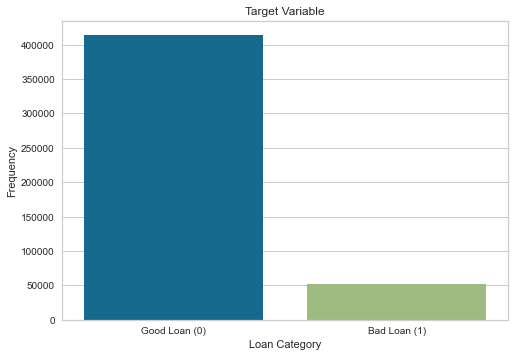

In [ ]:
x_label = ['Good Loan (0)', 'Bad Loan (1)']
sns.barplot(x = x_label, y = data.good_bad_loan.value_counts())
plt.xlabel('Loan Category')
plt.ylabel('Frequency')
plt.title('Target Variable')
plt.show()

The data is imbalance where the Bad_Loan(1) is much less than Good_Loan (0)

Data Cleaning

Drop Irrelevant Columns

In [ ]:
# Columns that have > 70% missing values
missing_values = data.isnull().mean()
missing_70 = missing_values[missing_values > 0.7]
missing_70

desc                           0.729815
mths_since_last_record         0.865666
mths_since_last_major_derog    0.787739
annual_inc_joint               1.000000
dti_joint                      1.000000
verification_status_joint      1.000000
open_acc_6m                    1.000000
open_il_6m                     1.000000
open_il_12m                    1.000000
open_il_24m                    1.000000
mths_since_rcnt_il             1.000000
total_bal_il                   1.000000
il_util                        1.000000
open_rv_12m                    1.000000
open_rv_24m                    1.000000
max_bal_bc                     1.000000
all_util                       1.000000
inq_fi                         1.000000
total_cu_tl                    1.000000
inq_last_12m                   1.000000
dtype: float64

In [ ]:
columns_to_drop = ['id', 'member_id', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d',
                  'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee', 'desc', 'mths_since_last_record',
                  'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m',
                  'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
                  'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m','policy_code', 'pymnt_plan']
data = data.drop(columns=columns_to_drop, axis=1)
data = data.dropna()

EDA

In [ ]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_bad_loan
42537,12000,12000,12000.0,36 months,6.621094,368.50,A,A2,10+ years,MORTGAGE,...,Jan-16,368.5000,Jan-16,0.0,INDIVIDUAL,0.0,0.0,267646.0,61100.0,0
42538,12000,12000,12000.0,36 months,13.531250,407.50,B,B5,10+ years,RENT,...,Sep-15,119.1875,Jan-16,0.0,INDIVIDUAL,0.0,15386.0,13605.0,8100.0,0
42539,15000,15000,15000.0,36 months,8.898438,476.25,A,A5,2 years,MORTGAGE,...,Jan-16,476.2500,Jan-16,0.0,INDIVIDUAL,0.0,1514.0,272492.0,15400.0,0
42541,14000,14000,14000.0,36 months,12.851562,470.75,B,B4,4 years,RENT,...,Jan-16,470.7500,Jan-16,0.0,INDIVIDUAL,0.0,0.0,17672.0,4500.0,0
42543,10000,10000,10000.0,36 months,9.671875,321.25,B,B1,7 years,MORTGAGE,...,Jan-16,321.2500,Jan-16,0.0,INDIVIDUAL,0.0,0.0,39143.0,22300.0,0


In [ ]:
def cat_stats(df, FEATURES):
    for feature in FEATURES:
        temp = df[feature].value_counts()
        df1 = pd.DataFrame({feature: temp.index, 'value': temp.values})
        cat_perc_0 = df[df['good_bad_loan'] == 0].groupby(feature).size().reset_index(name='Count_Target_0')
        cat_perc_1 = df[df['good_bad_loan'] == 1].groupby(feature).size().reset_index(name='Count_Target_1')
        cat_perc = cat_perc_0.merge(cat_perc_1, how='left', on=feature).fillna(0)
        cat_perc['Percentage_Target_0'] = cat_perc['Count_Target_0'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc['Percentage_Target_1'] = cat_perc['Count_Target_1'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc.sort_values(by=feature, inplace=True)

        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))

        sns.set_color_codes("pastel")

        # Plot distribution for TARGET == 0
        sns.barplot(ax=ax1, x=feature, y="Percentage_Target_0", data=cat_perc)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

        # Plot distribution for TARGET == 1
        sns.barplot(ax=ax2, x=feature, y='Percentage_Target_1', data=cat_perc)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.show()

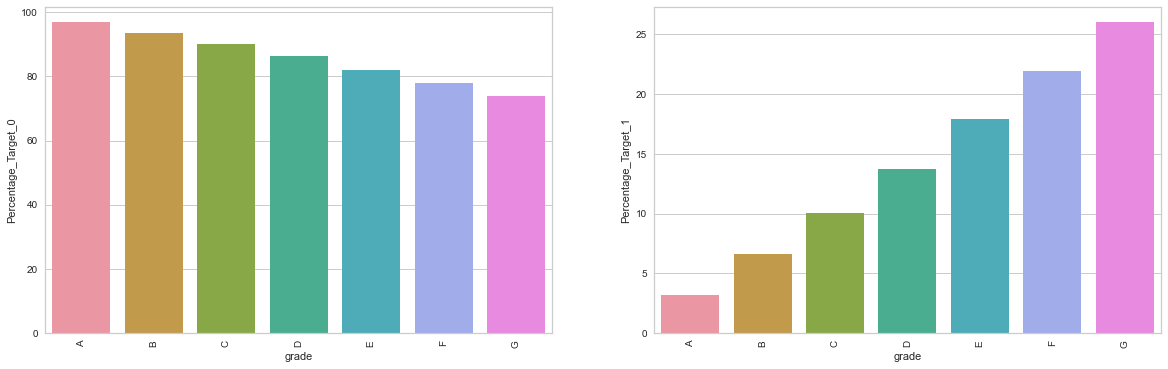

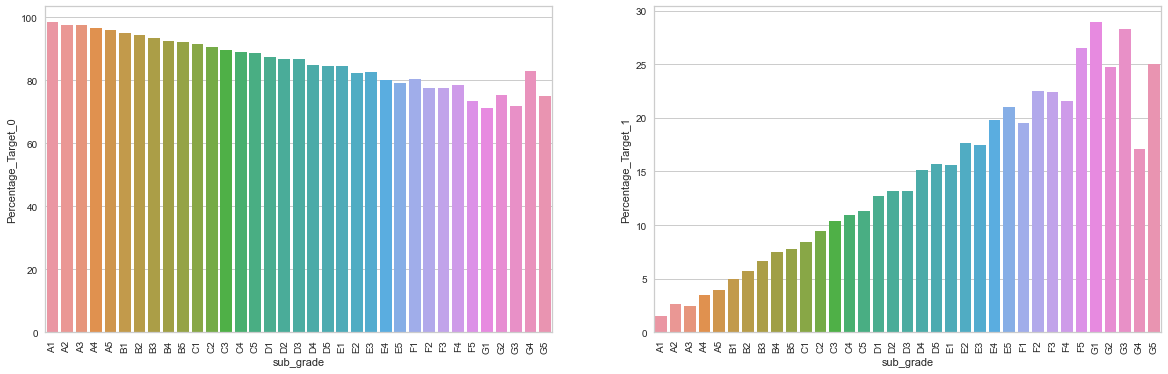

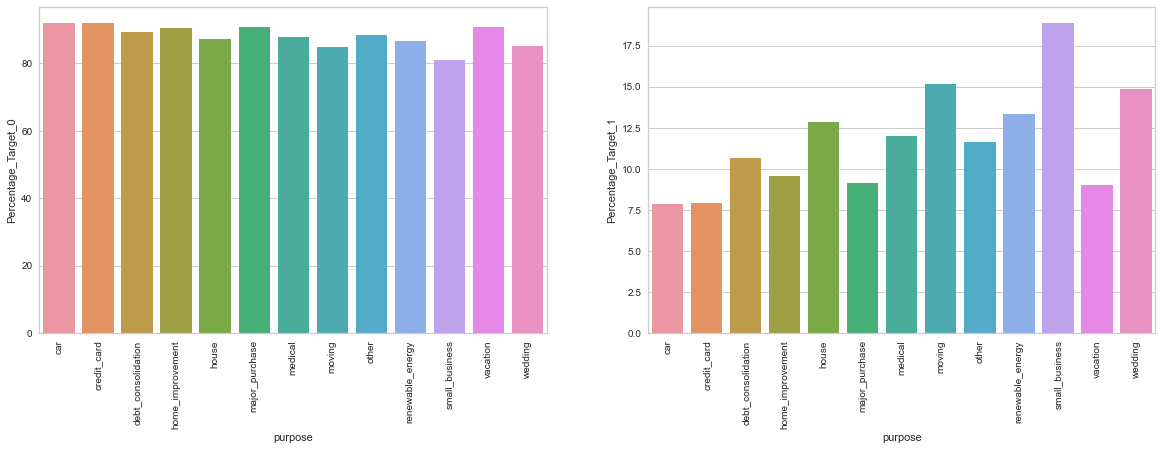

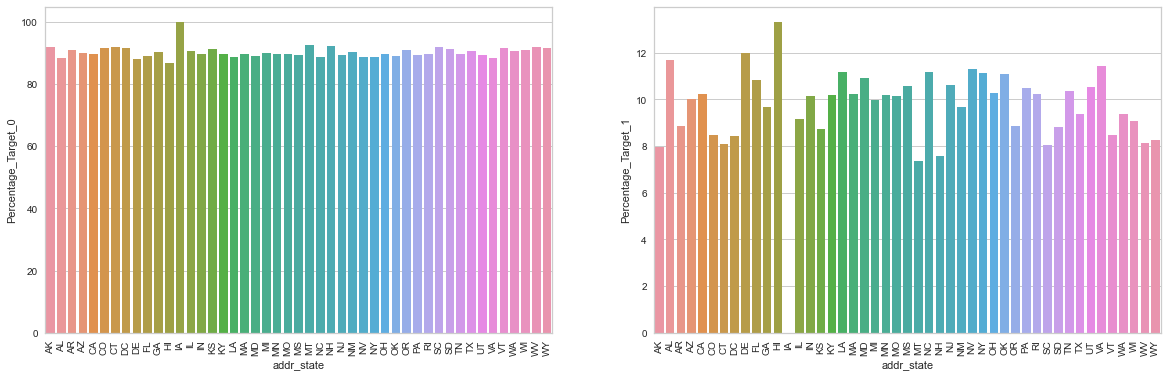

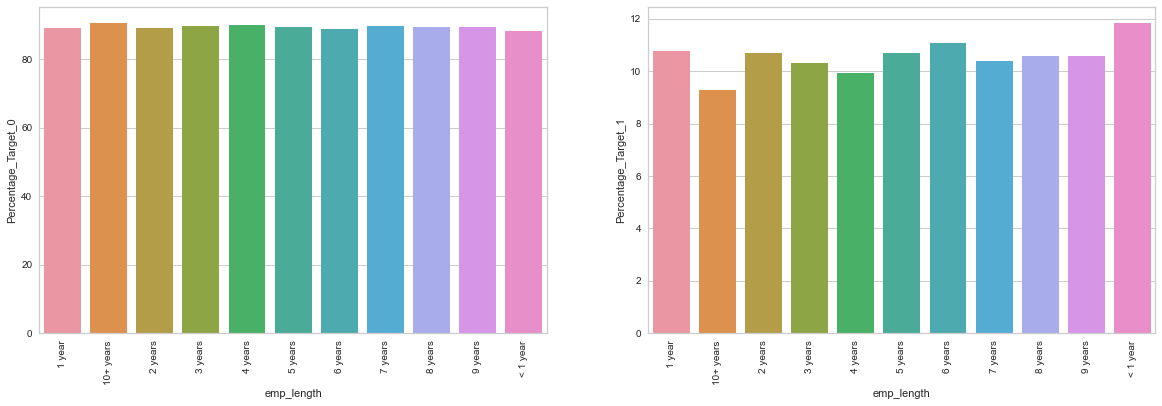

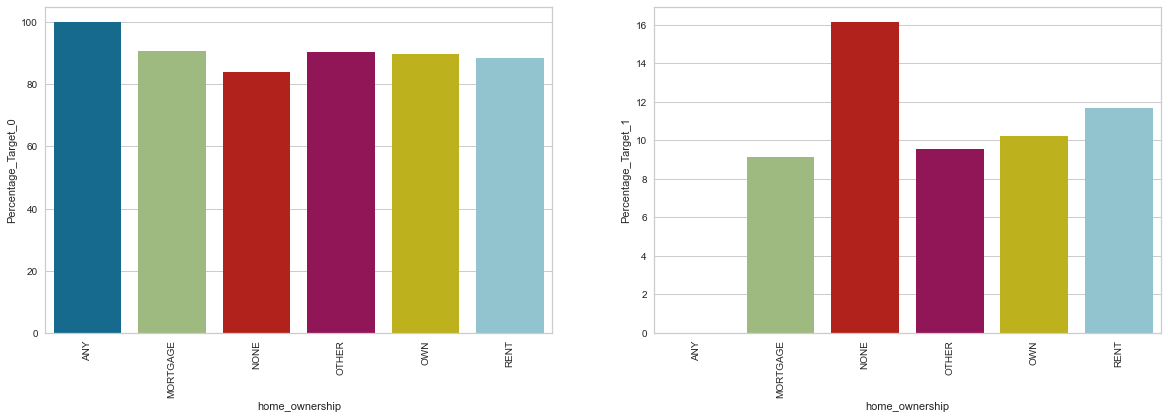

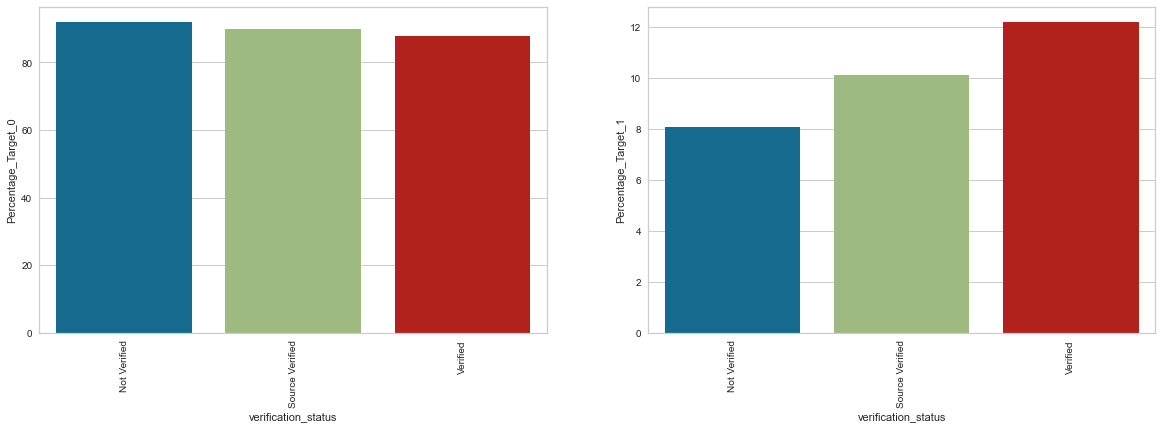

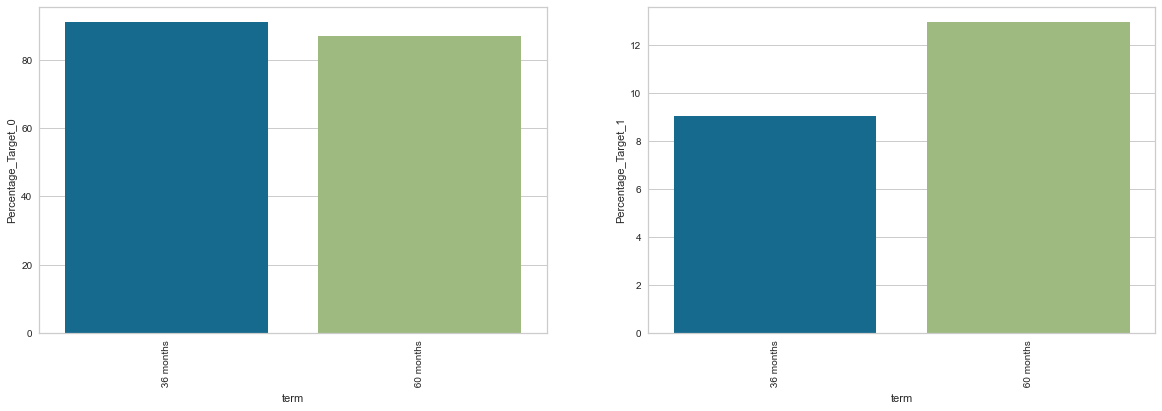

In [ ]:
important_features = ['grade', 'sub_grade', 'purpose', 'addr_state', 'emp_length', 'home_ownership', 'verification_status', 'term']
cat_stats(data,important_features)

From the data, we know that:
- People with grade 'G', 'F', and 'E' are most likely not to pay back the loan, with subgrade G1 being the subgrade with the highest amount of default
- People that borrow the loan in order to support their small business, to move to a new house, and to get married are more likely to not pay back the loan
- People that live in Hawaii, Delaware, and Alabama are more likely to not pay back the loan. This could be due to the high daily needs' price in those are. Meanwhile people who live Iowa are more likely to pay back the loan
- People who just got employed are less likely to pay back the loan
- People who don't have a home and those who rent a place are less likely to pay back the loan
- Most of the people whose account is already verified is less likely to pay back the loan
- People who don't pay back the loan are the ones who submit their application in 60-month term

Correlation

C:\Users\cynti\AppData\Local\Temp\ipykernel_18148\1894342276.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(data.corr().fillna(0), dtype = np.bool)


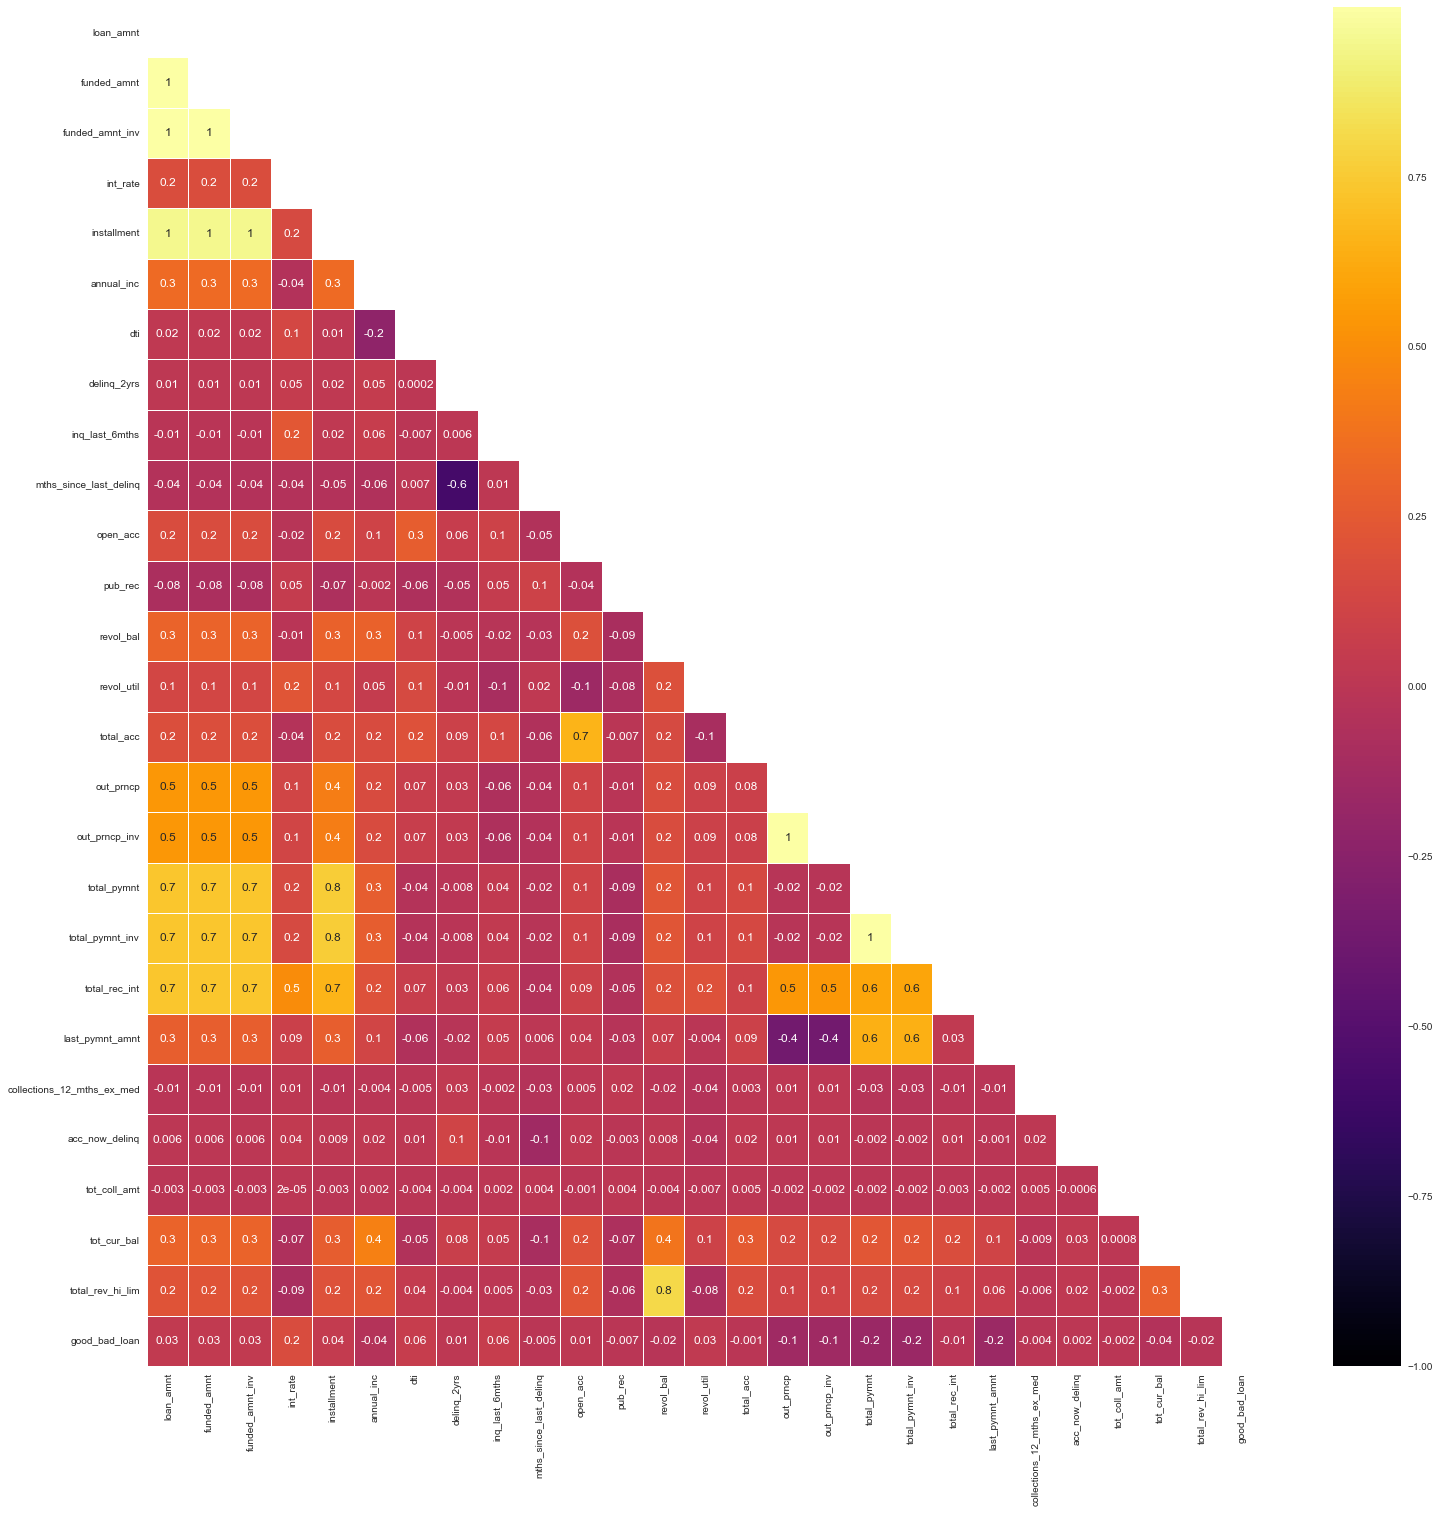

In [ ]:
mask = np.zeros_like(data.corr().fillna(0), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(25, 25))
sns.heatmap(data.corr(), mask = mask, annot = True,  cmap = "inferno", vmin = -1, fmt = '.1g', edgecolor = 'w', linewidth = 0.6)
plt.show()

Removing Multicolinear Features

In [ ]:
data = data.drop(columns=['loan_amnt', 'revol_bal', 'funded_amnt', 'funded_amnt_inv', 'installment',
                   'total_pymnt_inv',  'out_prncp_inv',  'total_acc', 'sub_grade'], axis = 1)

C:\Users\cynti\AppData\Local\Temp\ipykernel_18148\2757446890.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(data.corr().fillna(0), dtype=np.bool)


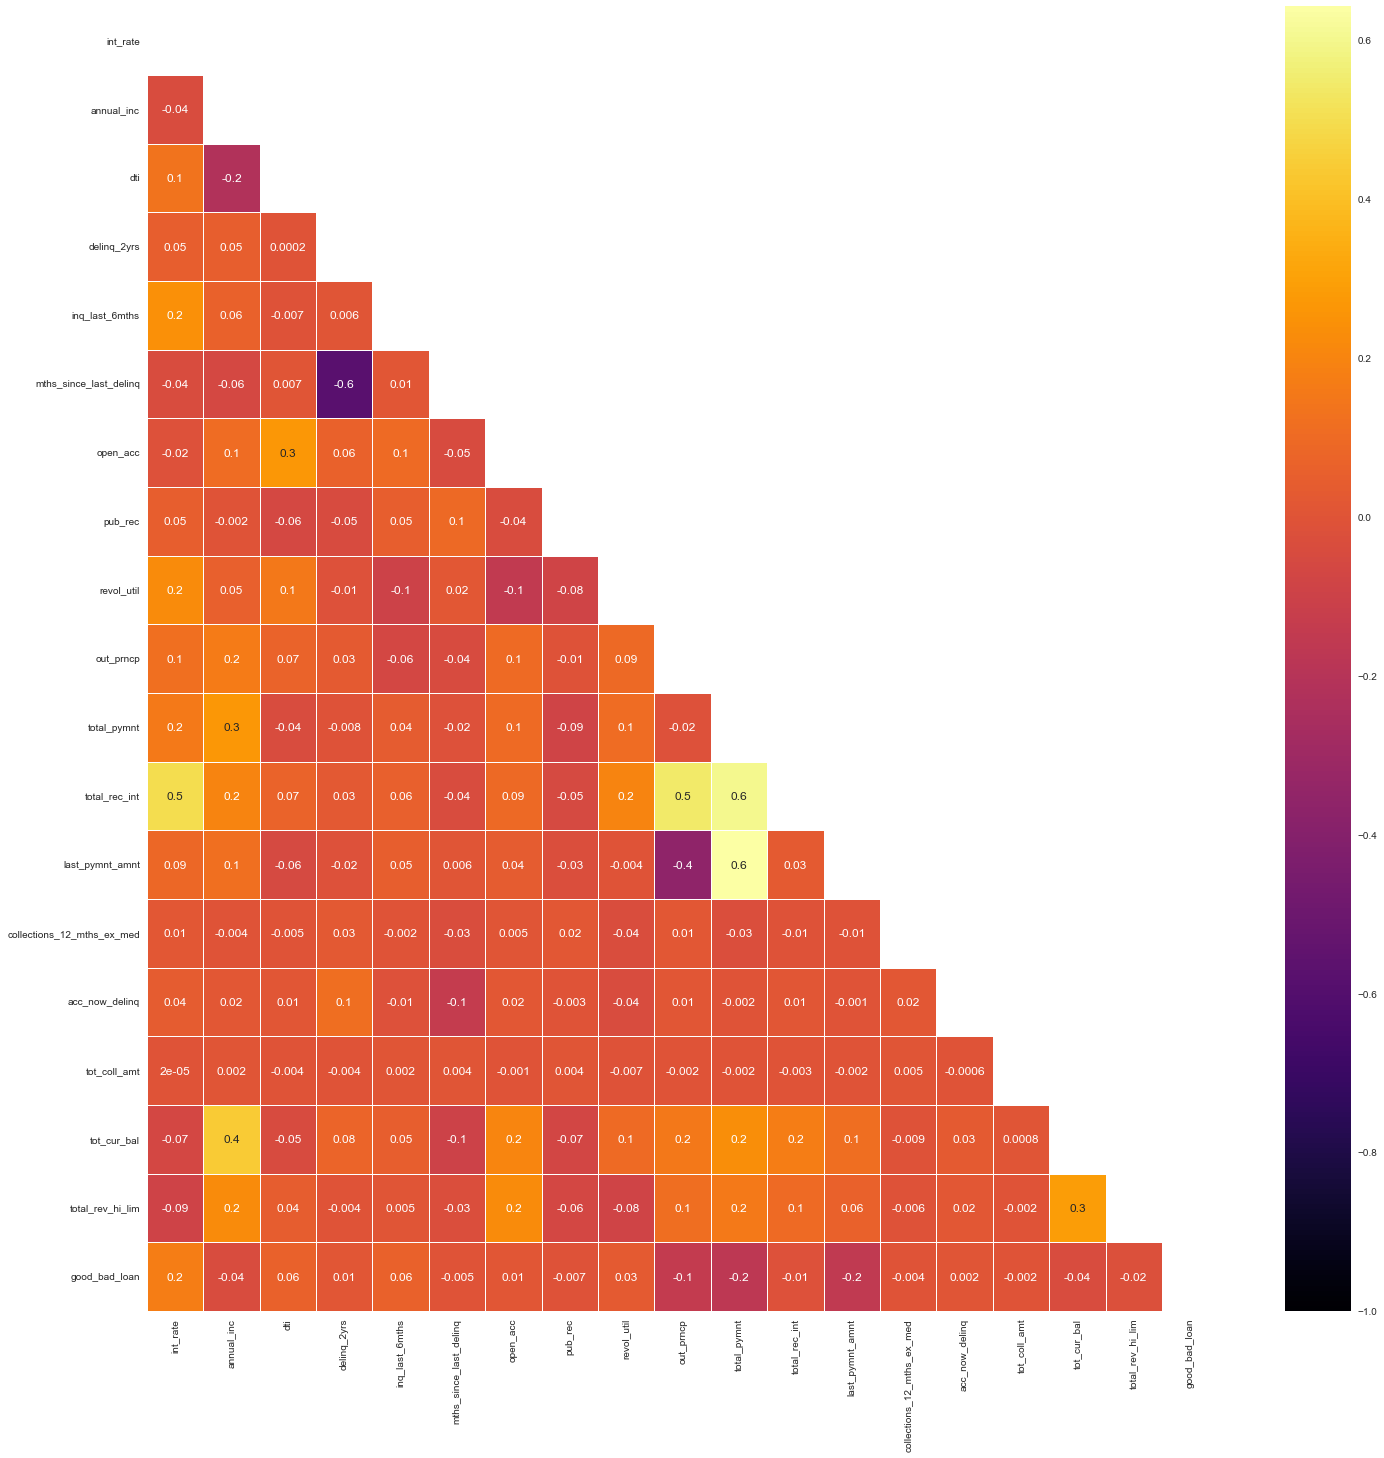

In [ ]:
mask = np.zeros_like(data.corr().fillna(0), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,24))
sns.heatmap(data.corr(), mask=mask, annot=True,  cmap="inferno", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)
plt.show()

In [ ]:
data.describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_util,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_bad_loan
count,181686.000000,1.816860e+05,181686.00000,181686.0,181686.0,181686.0,181686.0,181686.000000,181686.00000,181686.0,181686.0000,181686.0,181686.000000,181686.000000,181686.000000,1.816860e+05,181686.000,1.816860e+05,181686.000000
mean,NaN,7.886202e+04,NaN,NaN,NaN,NaN,NaN,0.189331,NaN,NaN,NaN,NaN,NaN,0.016418,0.009811,3.263837e+02,150563.625,2.735204e+04,0.101604
std,0.000000,6.078012e+04,0.00000,0.0,0.0,0.0,0.0,0.557617,NaN,NaN,NaN,NaN,NaN,0.149048,0.107361,2.157712e+04,159559.625,4.243347e+04,0.302127
min,6.000000,4.000000e+03,0.00000,0.0,0.0,0.0,1.0,0.000000,0.00000,0.0,35.6875,0.0,0.010002,0.000000,0.000000,0.000000e+00,0.000,1.000000e+02,0.000000
25%,11.671875,5.000000e+04,11.53125,0.0,0.0,15.0,8.0,0.000000,40.31250,0.0,5484.0000,1037.0,321.250000,0.000000,0.000000,0.000000e+00,32451.250,1.230000e+04,0.000000
50%,14.156250,6.800000e+04,16.90625,0.0,0.0,30.0,11.0,0.000000,57.40625,2637.0,9128.0000,1926.0,540.000000,0.000000,0.000000,0.000000e+00,98471.500,2.060000e+04,0.000000
75%,17.140625,9.402825e+04,22.90625,1.0,1.0,49.0,14.0,0.000000,73.87500,8880.0,14688.0000,3432.0,3048.000000,0.000000,0.000000,0.000000e+00,225514.750,3.400000e+04,0.000000
max,26.062500,7.500000e+06,40.00000,29.0,7.0,188.0,84.0,21.000000,892.50000,31904.0,56096.0000,21840.0,36160.000000,20.000000,5.000000,9.152545e+06,8000078.000,9.999999e+06,1.000000


Data Type Transformation

In [ ]:
# converting emp_length to numeric and assign NaN to zero

def emp_length_convert(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)


emp_length_convert(data, 'emp_length')

data['emp_length'].unique()

C:\Users\cynti\AppData\Local\Temp\ipykernel_18148\3783665095.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\+ years', '')


array([10,  2,  4,  7,  6,  5,  8,  3,  1,  0,  9], dtype=int64)

In [ ]:
# converting term to numeric

def term_numeric(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

term_numeric(data, 'term')

In [ ]:
# preprocessing date cols

def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)


date_columns(data, 'issue_d')
date_columns(data, 'last_pymnt_d')
date_columns(data, 'last_credit_pull_d')
date_columns(data, 'earliest_cr_line')

In [ ]:
# seperating categorical features from numerical
categorical_features = data.select_dtypes(exclude='number')
numerical_features = data.select_dtypes(exclude='object')

In [ ]:
data = data.reset_index()

In [ ]:
preprocess_data = data.copy()

#checking for any missing values
missing = preprocess_data.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

Binning, Weight of Evidence, and Information Value

In [ ]:
#function to calculate Weight of Evidence (WoE) and Information Value (IV)

def iv_woe(data, target, bins=10, show_woe=False):

    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    cols = data.columns

    #Run WoE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp = pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF = pd.concat([newDF,temp], axis=0)
        woeDF = pd.concat([woeDF,d], axis=0)

        if show_woe == True:
            print(d)

    return newDF, woeDF

iv, woe = iv_woe(preprocess_data, target = 'good_bad_loan', bins=20)

Information value of index is 0.062364
Information value of term is 0.035331
Information value of int_rate is 0.342658
Information value of grade is 0.280322
Information value of emp_length is 0.007239
Information value of home_ownership is 0.016678
Information value of annual_inc is 0.036486
Information value of verification_status is 0.033189
Information value of purpose is 0.028835
Information value of addr_state is 0.010225
Information value of dti is 0.040523
Information value of delinq_2yrs is 0.001209
Information value of inq_last_6mths is 0.039326
Information value of mths_since_last_delinq is 0.002684
Information value of open_acc is 0.004182
Information value of pub_rec is 0.00032
Information value of revol_util is 0.009051
Information value of initial_list_status is 0.010038
Information value of out_prncp is 0.595852
Information value of total_pymnt is 0.492097
Information value of total_rec_int is 0.008597
Information value of last_pymnt_amnt is 1.475572
Information value o

The rule of thumb says that all variables with IV < 0.02 are not useful for prediction and IV > 0.5 have a suspicious predictive power. Therefore, the follwing variables will not be included out_prncp, last_pymnt_amnt, delinq_2yrs, mths_since_last_delinq, open_acc, pub_rec, total_acc, collections_12_mths_ex_med, acc_now_delinq, tot_coll_amt and mths_since_last_pymnt_d

In [ ]:
#drop columns with low IV
preprocess_data = preprocess_data.drop(columns=['last_pymnt_amnt', 'revol_util', 'delinq_2yrs', 'mths_since_last_delinq',
                              'open_acc', 'pub_rec',  'collections_12_mths_ex_med', 'acc_now_delinq',
                              'tot_coll_amt', 'mths_since_last_pymnt_d', 'emp_length', 'application_type'], axis=1)
preprocess_data = preprocess_data.drop(columns = 'index', axis = 1)

In [ ]:
# dummy variables for cat cols
data_dummies1 = [pd.get_dummies(preprocess_data['grade'], prefix='grade', prefix_sep=':'),
                 pd.get_dummies(preprocess_data['home_ownership'], prefix='home_ownership', prefix_sep=':'),
                 pd.get_dummies(preprocess_data['verification_status'], prefix='verification_status', prefix_sep=':'),
                 pd.get_dummies(preprocess_data['purpose'], prefix='purpose', prefix_sep=':'),
                 pd.get_dummies(preprocess_data['addr_state'], prefix='addr_state', prefix_sep=':'),
                 pd.get_dummies(preprocess_data['initial_list_status'], prefix='initial_list_status', prefix_sep=':')
                ]

In [ ]:
# turn  data_dummies into dataframe

categorical_dummies = pd.concat(data_dummies1, axis=1)
# concatinating preprocess_data with categorical_dummies

preprocess_data = pd.concat([preprocess_data, categorical_dummies], axis=1)

Separating Data into Target and Features

In [ ]:
#seperating data into target and features
X = preprocess_data.drop(columns='good_bad_loan', axis=1)
y = preprocess_data['good_bad_loan']

In [ ]:
# grade

new_df = preprocess_data.loc[:, 'grade:A':'grade:G']

# home_ownership

new_df['home_ownership:OWN'] = preprocess_data.loc[:, 'home_ownership:OWN']
new_df['home_ownership:OTHER_NONE_RENT_ANY'] = sum([preprocess_data['home_ownership:OTHER'],
                                                    preprocess_data['home_ownership:NONE'],
                                                    preprocess_data['home_ownership:RENT'],
                                                    preprocess_data['home_ownership:ANY']])
new_df['home_ownership:MORTGAGE'] = preprocess_data.loc[:, 'home_ownership:MORTGAGE']

#verification status
new_df['verification_status:NOT_VERIFIED'] = preprocess_data.loc[:, 'verification_status:Not Verified']
new_df['verification_status:SOURCE_VERIFIED'] = preprocess_data.loc[:, 'verification_status:Source Verified']
new_df['verification_status:VERIFIED'] = preprocess_data.loc[:, 'verification_status:Verified']

# purpose of loan
new_df['purpose:SMALL_BUSINESS_EDUCATIONAL_RENEWABLE_ENERGY_MOVING'] = sum([preprocess_data['purpose:small_business'],  preprocess_data['purpose:renewable_energy'], preprocess_data['purpose:moving']])
new_df['purpose:OTHER_HOUSE_MEDICAL'] =sum([preprocess_data['purpose:other'], preprocess_data['purpose:house'], preprocess_data['purpose:medical']])
new_df ['purpose:WEDDING_VACATION'] = sum([preprocess_data['purpose:wedding'], preprocess_data['purpose:vacation']])
new_df ['purpose:HOME_IMPROVEMENT_MAJOR_PURCHASE'] = sum([preprocess_data['purpose:home_improvement'], preprocess_data['purpose:major_purchase']])
new_df ['purpose:CAR_CREDIT_CARD'] = sum([preprocess_data['purpose:car'], preprocess_data['purpose:credit_card']])


# addr state
new_df['addr_state:NE_IA_NV_HI_FL_AL'] =sum([preprocess_data['addr_state:IA'],preprocess_data['addr_state:NV'],
                                             preprocess_data['addr_state:HI'],preprocess_data['addr_state:FL'],
                                             preprocess_data['addr_state:AL']])
new_df['addr_state:NY'] = preprocess_data.loc[:, 'addr_state:NY']
new_df['addr_state:LA_NM_OK_NC_MO_MD_NJ_VA'] = sum([preprocess_data['addr_state:LA'],preprocess_data['addr_state:NM'],preprocess_data['addr_state:OK'],
                                                    preprocess_data['addr_state:NC'],preprocess_data['addr_state:MO'],preprocess_data['addr_state:MD'], preprocess_data['addr_state:NJ'],
                                                    preprocess_data['addr_state:VA']])
new_df['addr_state:CA'] = preprocess_data.loc[:,'addr_state:CA']
new_df['addr_state:AZ_MI_UT_TN_AR_PA'] =sum([preprocess_data['addr_state:AZ'],preprocess_data['addr_state:MI'],preprocess_data['addr_state:UT'],
preprocess_data['addr_state:TN'],preprocess_data['addr_state:AR'],preprocess_data['addr_state:PA']])

new_df['addr_state:RI_OH_KY_DE_MN_SD_MA_IN'] =sum([preprocess_data['addr_state:RI'],preprocess_data['addr_state:OH'],preprocess_data['addr_state:KY'],
                                                   preprocess_data['addr_state:DE'],preprocess_data['addr_state:MN'],preprocess_data['addr_state:SD'],preprocess_data['addr_state:MA'],
                                                   preprocess_data['addr_state:IN']])

new_df['addr_state:GA_WA'] = sum([preprocess_data['addr_state:GA'], preprocess_data['addr_state:WA']])
new_df['addr_state:WI_OR'] = sum([preprocess_data['addr_state:WI'], preprocess_data['addr_state:OR']])
new_df['addr_state:TX'] = preprocess_data.loc[:,'addr_state:TX']
new_df['addr_state:IL_CT_MT'] =sum([preprocess_data['addr_state:IL'],preprocess_data['addr_state:CT'],preprocess_data['addr_state:MT']])
new_df['addr_state:CO_SC'] = sum([preprocess_data['addr_state:CO'], preprocess_data['addr_state:SC']])
new_df['addr_state:KS_VT_AK_NS'] =sum([preprocess_data['addr_state:KS'],preprocess_data['addr_state:VT'],preprocess_data['addr_state:AK'],
                                           preprocess_data['addr_state:MS']])
new_df['addr_state:NH_WV_WY_DC'] =sum([preprocess_data['addr_state:NH'],preprocess_data['addr_state:WV'],preprocess_data['addr_state:WY'],
                                           preprocess_data['addr_state:DC']])
#initial_list_status
new_df['initial_list_status:F'] = preprocess_data.loc[:, 'initial_list_status:f']
new_df['initial_list_status:W'] = preprocess_data.loc[:, 'initial_list_status:w']

# term
new_df['term:36'] = np.where((preprocess_data['term'] == 36), 1, 0)
new_df['term:60'] = np.where((preprocess_data['term']==60), 1,0)

#total_rec_int
new_df['total_rec_int:<1000'] = np.where((preprocess_data['total_rec_int']<=1000), 1,0)
new_df['total_rec_int:1000-2000'] = np.where((preprocess_data['total_rec_int']>1000) &(preprocess_data['total_rec_int']<=2000), 1,0)
new_df['total_rec_int:2000-9000'] = np.where((preprocess_data['total_rec_int']>2000) &(preprocess_data['total_rec_int']<=9000), 1,0)
new_df['total_rec_int:>9000'] = np.where((preprocess_data['total_rec_int']>9000), 1,0)


#total_revol_hi_lim
new_df['total_rev_hi_lim:<10000'] =np.where((preprocess_data['total_rev_hi_lim']<=10000),1,0)
new_df['total_rev_hi_lim:10000-20000'] =np.where((preprocess_data['total_rev_hi_lim']>10000)&(preprocess_data['total_rev_hi_lim']<=20000),1,0)
new_df['total_rev_hi_lim:20000-40000'] =np.where((preprocess_data['total_rev_hi_lim']>20000)&(preprocess_data['total_rev_hi_lim']<=40000),1,0)
new_df['total_rev_hi_lim:40000-60000'] =np.where((preprocess_data['total_rev_hi_lim']>40000)&(preprocess_data['total_rev_hi_lim']<=60000),1,0)
new_df['total_rev_hi_lim:60000-80000'] =np.where((preprocess_data['total_rev_hi_lim']>60000)&(preprocess_data['total_rev_hi_lim']<=80000),1,0)
new_df['total_rev_hi_lim:80000-100000'] =np.where((preprocess_data['total_rev_hi_lim']>80000)&(preprocess_data['total_rev_hi_lim']<=100000),1,0)
new_df['total_rev_hi_lim:<100000'] =np.where((preprocess_data['total_rev_hi_lim']>100000),1,0)


#total_pymnt
new_df['total_pymnt:<5000'] = np.where((preprocess_data['total_pymnt']<=5000), 1,0)
new_df['total_pymnt:5000-11000'] = np.where((preprocess_data['total_pymnt']>5000)&(preprocess_data['total_pymnt']<=11000),1,0)
new_df['total_pymnt:11000-16000'] = np.where((preprocess_data['total_pymnt']>11000)&(preprocess_data['total_pymnt']<=16000),1,0)
new_df['total_pymnt:16000-22000'] = np.where((preprocess_data['total_pymnt']>16000)&(preprocess_data['total_pymnt']<=22000),1,0)
new_df['total_pymnt:>22000'] = np.where((preprocess_data['total_pymnt']<=5000), 1,0)
#int_Rate

new_df['int_rate:<7.484'] = np.where((preprocess_data['int_rate'] <= 7.484), 1, 0)
new_df['int_rate:7.484-9.548'] = np.where((preprocess_data['int_rate'] > 7.484) & (preprocess_data['int_rate'] <= 9.548), 1, 0)
new_df['int_rate:9.548-11.612'] = np.where((preprocess_data['int_rate'] > 9.548) & (preprocess_data['int_rate'] <= 11.612), 1, 0)
new_df['int_rate:11.612-13.676'] = np.where((preprocess_data['int_rate'] > 11.612) & (preprocess_data['int_rate'] <= 13.676), 1, 0)
new_df['int_rate:13.676-15.74'] = np.where((preprocess_data['int_rate'] > 13.676) & (preprocess_data['int_rate'] <= 15.74), 1, 0)
new_df['int_rate:15.74-17.804'] = np.where((preprocess_data['int_rate'] > 15.74) & (preprocess_data['int_rate'] <= 17.804), 1, 0)
new_df['int_rate:17.804-19.868'] = np.where((preprocess_data['int_rate'] > 17.804) & (preprocess_data['int_rate'] <= 19.868), 1, 0)
new_df['int_rate:7.19.868-21.932'] = np.where((preprocess_data['int_rate'] > 19.868) & (preprocess_data['int_rate'] <= 21.932), 1, 0)
new_df['int_rate:21.932-26.06'] = np.where((preprocess_data['int_rate'] > 21.932) & (preprocess_data['int_rate'] <= 26.06), 1, 0)


#dti
new_df['dti:<4'] = np.where((preprocess_data['dti'] <=4), 1, 0)
new_df['dti:4-8'] = np.where((preprocess_data['dti'] > 4) & (preprocess_data['dti'] <= 8), 1, 0)
new_df['dti:8-12'] = np.where((preprocess_data['dti'] > 8) & (preprocess_data['dti'] <= 12), 1, 0)
new_df['dti:12-16'] = np.where((preprocess_data['dti'] > 12) & (preprocess_data['dti'] <= 16), 1, 0)
new_df['dti:16-20'] = np.where((preprocess_data['dti'] > 16) & (preprocess_data['dti'] <= 20), 1, 0)
new_df['dti:20-23'] = np.where((preprocess_data['dti'] > 20) & (preprocess_data['dti'] <= 23), 1, 0)
new_df['dti:23-27'] = np.where((preprocess_data['dti'] > 23) & (preprocess_data['dti'] <= 27), 1, 0)
new_df['dti:27-40'] = np.where((preprocess_data['dti'] > 27) & (preprocess_data['dti'] <= 40), 1, 0)

#annual income
new_df['annual_inc:<32000'] = np.where((preprocess_data['annual_inc'] <= 32000), 1, 0)
new_df['annual_inc:32000-50000'] = np.where((preprocess_data['annual_inc'] > 32000) & (preprocess_data['annual_inc'] <= 50000),1, 0)
new_df['annual_inc:32000-50000'] = np.where((preprocess_data['annual_inc'] > 32000) & (preprocess_data['annual_inc'] <= 50000), 1, 0)
new_df['annual_inc:50000-60000'] = np.where((preprocess_data['annual_inc'] > 50000) & (preprocess_data['annual_inc'] <= 60000), 1, 0)
new_df['annual_inc:60000-75000'] = np.where((preprocess_data['annual_inc'] > 60000) & (preprocess_data['annual_inc'] <= 75000), 1, 0)
new_df['annual_inc:75000-90000'] = np.where((preprocess_data['annual_inc'] > 75000) & (preprocess_data['annual_inc'] <= 90000), 1, 0)
new_df['annual_inc:90000-120000'] = np.where((preprocess_data['annual_inc'] > 90000) & (preprocess_data['annual_inc'] <= 120000), 1, 0)
new_df['annual_inc:120000-135000'] = np.where((preprocess_data['annual_inc'] > 120000) & (preprocess_data['annual_inc'] <= 135000), 1, 0)
new_df['annual_inc:135000-150000'] = np.where((preprocess_data['annual_inc'] > 135000) & (preprocess_data['annual_inc'] <= 150000), 1, 0)
new_df['annual_inc:>150000'] = np.where((preprocess_data['annual_inc'] > 150000), 1, 0)

#inq_last_6mths
new_df['inq_last_6mths:<1'] = np.where((preprocess_data['inq_last_6mths'] <=1), 1, 0)
new_df['inq_last_6mths:1-2'] = np.where((preprocess_data['inq_last_6mths'] >1)& (preprocess_data['inq_last_6mths']<=2),  1, 0)
new_df['inq_last_6mths:2-4'] = np.where((preprocess_data['inq_last_6mths'] >2)& (preprocess_data['inq_last_6mths']<=4),  1, 0)
new_df['inq_last_6mths:4-7'] = np.where((preprocess_data['inq_last_6mths'] >4)& (preprocess_data['inq_last_6mths']<=7),  1, 0)

#tot_cur_balance
new_df['tot_cur_bal:<40000'] = np.where((preprocess_data['tot_cur_bal'] <= 40000), 1, 0)
new_df['tot_cur_bal:40000-80000'] = np.where((preprocess_data['tot_cur_bal'] > 40000) & (preprocess_data['tot_cur_bal'] <= 80000), 1, 0)
new_df['tot_cur_bal:80000-120000'] = np.where((preprocess_data['tot_cur_bal'] > 120000) & (preprocess_data['tot_cur_bal'] <= 160000), 1, 0)
new_df['tot_cur_bal:120000-160000'] = np.where((preprocess_data['tot_cur_bal'] > 120000) & (preprocess_data['tot_cur_bal'] <= 160000), 1, 0)
new_df['tot_cur_bal:160000-200000'] = np.where((preprocess_data['tot_cur_bal'] > 160000) & (preprocess_data['tot_cur_bal'] <= 200000), 1, 0)
new_df['tot_cur_bal:200000-240000'] = np.where((preprocess_data['tot_cur_bal'] > 200000) & (preprocess_data['tot_cur_bal'] <= 240000), 1, 0)
new_df['tot_cur_bal:240000-320000'] = np.where((preprocess_data['tot_cur_bal'] > 240000) & (preprocess_data['tot_cur_bal'] <= 320000), 1, 0)
new_df['tot_cur_bal:320000-400000'] = np.where((preprocess_data['tot_cur_bal'] > 320000) & (preprocess_data['tot_cur_bal'] <= 400000), 1, 0)
new_df['tot_cur_bal:>400000'] = np.where((preprocess_data['tot_cur_bal'] > 400000), 1, 0)

#mths_since_last_credit_pull_d
new_df['mths_since_last_credit_pull_d:<65'] = np.where((preprocess_data['mths_since_last_credit_pull_d']<=65), 1,0)
new_df['mths_since_last_credit_pull_d:65-76'] = np.where((preprocess_data['mths_since_last_credit_pull_d']>65)&(preprocess_data['mths_since_last_credit_pull_d']<=76),1,0)
new_df['mths_since_last_credit_pull_d:>76'] = np.where((preprocess_data['mths_since_last_credit_pull_d']>76), 1,0)

#mths_since_issue_d_factor
new_df['mths_since_issue_d_:<70.8'] = np.where((preprocess_data['mths_since_issue_d']<=70.8), 1,0)
new_df['mths_since_issue_d_:>70.8-73.6'] = np.where((preprocess_data['mths_since_issue_d'] >70.8) & (preprocess_data['mths_since_issue_d']<=73.6), 1,0)
new_df['mths_since_issue_d_:73.6-76.4'] = np.where((preprocess_data['mths_since_issue_d']>70.8) & (preprocess_data['mths_since_issue_d']<=76.4), 1,0)
new_df['mths_since_issue_d_:>76.4-79.2'] = np.where((preprocess_data['mths_since_issue_d'] >76.4) & (preprocess_data['mths_since_issue_d']<=79.2), 1,0)
new_df['mths_since_issue_d_:>79.2-82'] = np.where((preprocess_data['mths_since_issue_d'] >79.2) & (preprocess_data['mths_since_issue_d']<=82), 1,0)
new_df['mths_since_issue_d_>82-84'] = np.where((preprocess_data['mths_since_issue_d'] >82) & (preprocess_data['mths_since_issue_d']<=84), 1,0)
new_df['mths_since_issue_d_:>84-90.4'] = np.where((preprocess_data['mths_since_issue_d'] >84) & (preprocess_data['mths_since_issue_d']<=90.4), 1,0)
new_df['mths_since_issue_d_:>90.4-96'] = np.where((preprocess_data['mths_since_issue_d'] >90.4) & (preprocess_data['mths_since_issue_d']<=96), 1,0)

new_df['out_prncp:<3000'] = np.where((preprocess_data['out_prncp']<=3000), 1,0)
new_df['out_prncp:3000-6000'] = np.where((preprocess_data['out_prncp']>3000)&(preprocess_data['out_prncp']<=6000), 1,0)
new_df['out_prncp:6000-10000'] = np.where((preprocess_data['out_prncp']>6000)&(preprocess_data['out_prncp']<=10000), 1,0)
new_df['out_prncp:10000-12000'] = np.where((preprocess_data['out_prncp']>10000)&(preprocess_data['out_prncp']<=12000), 1,0)
new_df['out_prncp:>12000'] = np.where((preprocess_data['out_prncp']>12000), 1,0)

new_df['good_bad_loan'] = preprocess_data.loc[:, 'good_bad_loan']

C:\Users\cynti\AppData\Local\Temp\ipykernel_18148\3777616017.py:156: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['good_bad_loan'] = preprocess_data.loc[:, 'good_bad_loan']


In [ ]:
#dummy categories to drop
ref_categories = ['home_ownership:OTHER_NONE_RENT_ANY', 'total_rec_int:<1000', 'total_pymnt:<5000','total_rev_hi_lim:<10000', 'grade:G', 'verification_status:VERIFIED', 'purpose:SMALL_BUSINESS_EDUCATIONAL_RENEWABLE_ENERGY_MOVING',
                 'addr_state:NE_IA_NV_HI_FL_AL', 'initial_list_status:F', 'term:60', 'mths_since_issue_d_:>90.4-96','int_rate:21.932-26.06', 'dti:27-40',
                 'annual_inc:<32000', 'inq_last_6mths:4-7', 'tot_cur_bal:<40000', 'mths_since_last_credit_pull_d:>76', 'out_prncp:>12000']
#col dropped
new_df = new_df.drop(columns=ref_categories, axis=1)

In [ ]:
new_df

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,verification_status:NOT_VERIFIED,verification_status:SOURCE_VERIFIED,...,mths_since_issue_d_:73.6-76.4,mths_since_issue_d_:>76.4-79.2,mths_since_issue_d_:>79.2-82,mths_since_issue_d_>82-84,mths_since_issue_d_:>84-90.4,out_prncp:<3000,out_prncp:3000-6000,out_prncp:6000-10000,out_prncp:10000-12000,good_bad_loan
0,1,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181681,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
181682,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
181683,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
181684,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [ ]:
#seperating data into target and features
X = new_df.drop(columns = 'good_bad_loan', axis = 1)
y = new_df['good_bad_loan']

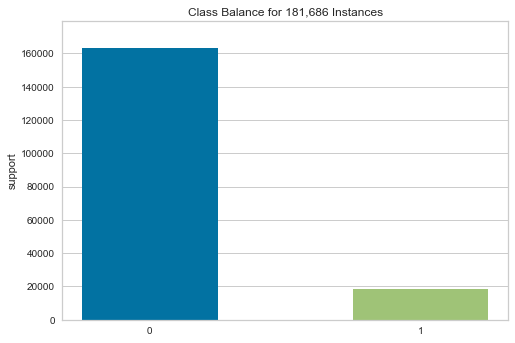

<AxesSubplot:title={'center':'Class Balance for 181,686 Instances'}, ylabel='support'>

In [ ]:
# check if class labels are balanced

from yellowbrick.target import ClassBalance
X = new_df.drop(columns='good_bad_loan', axis=1)
y = new_df['good_bad_loan']
visualizer = ClassBalance()
visualizer.fit(y)
visualizer.show()

Splitting Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 42)

Oversampling the Data to Treat Imbalance

In [ ]:
#dealing with imbalanced data
os = RandomOverSampler()
X_train, y_train = os.fit_resample(X_train, y_train)
y_train_series = pd.Series(y_train)
#check value counts after oversampling
y_train_series.value_counts()

0    114286
1    114286
Name: good_bad_loan, dtype: int64

Data Training using Logistic Regression, Random Forest, AdaBoost, and GradientBoosting

Our goal here is to find a model with the highest recall for target 1. This is done to minimize the risk of accepting bad loan as good loan and reduce financial risk.

Confusion Matrix Function

In [ ]:
def plot_confusion_matrix(test_y, predicted_y):
    # Confusion matrix
    C = confusion_matrix(test_y, predicted_y)

    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)

    # Precision matrix
    B = (C/C.sum(axis=0))

    plt.figure(figsize=(20,4))

    labels = ['Good_Loan(0)','Bad_Loan(1)']
    cmap=sns.light_palette("purple")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap= 'Blues',fmt="d", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Confusion matrix')

    plt.subplot(1,3,2)
    sns.heatmap(A, annot=True, cmap= 'Blues', xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Recall matrix')

    plt.subplot(1,3,3)
    sns.heatmap(B, annot=True, cmap= 'Blues', xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Precision matrix')

    plt.show()
def cv_plot(alpha, cv_auc):

    fig, ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_auc,c='g')
    for i, txt in enumerate(np.round(cv_auc,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

Logistic Regression

In [ ]:
logreg = LogisticRegression(C = 10, random_state = 99, solver = 'lbfgs')
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print(classification_report(y_test, y_pred_logreg))
print(confusion_matrix(y_pred_logreg, y_test))
print('The percentage of misclassified points = {:05.2f}%'.format((1-accuracy_score(y_test, y_pred_logreg))*100))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86     48940
           1       0.28      0.78      0.41      5566

    accuracy                           0.77     54506
   macro avg       0.62      0.78      0.64     54506
weighted avg       0.90      0.77      0.81     54506

[[37856  1232]
 [11084  4334]]
The percentage of misclassified points = 22.60%


c:\Users\cynti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_hat_test_proba_log = logreg.predict_proba(X_test)
y_hat_test_proba_log = y_hat_test_proba_log[:][: , 1]
y_test_temp_log = y_test.copy()
y_test_temp_log.reset_index(drop = True, inplace = True)
y_test_proba_log = pd.concat([y_test_temp_log, pd.DataFrame(y_hat_test_proba_log), pd.DataFrame(y_pred_logreg)], axis = 1)
y_test_proba_log.columns = ['y_test_class_actual', 'y_hat_test_proba', 'y_hat_test']
y_test_proba_log.index = X_test.index
y_test_proba_log.head()

,y_test_class_actual,y_hat_test_proba,y_hat_test
19526,0,0.083606,0
51480,1,0.475366,0
50371,0,0.494884,0
85705,0,0.194334,0
11738,0,0.317170,0


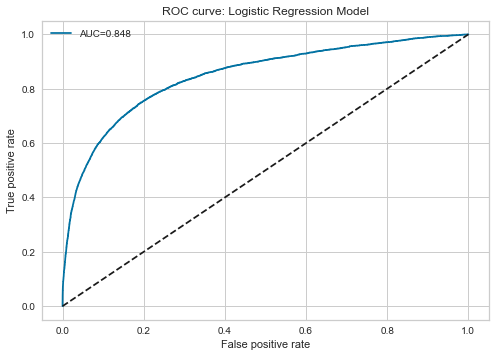

In [ ]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba_log['y_test_class_actual'], y_test_proba_log['y_hat_test_proba'])
AUROC_log = roc_auc_score(y_test_proba_log['y_test_class_actual'], y_test_proba_log['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, to plot randomness of model
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(["AUC=%.3f"%AUROC_log])
plt.title('ROC curve: Logistic Regression Model');

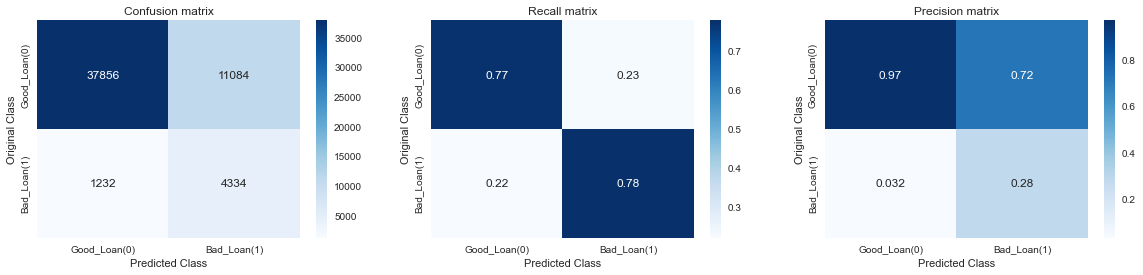

In [ ]:
plot_confusion_matrix(y_test, y_pred_logreg)

Random Forest

In [ ]:
rf = RandomForestClassifier(criterion='entropy', n_estimators=200, random_state = 99)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_pred_rf, y_test))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred_rf))*100))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     48940
           1       0.76      0.41      0.53      5566

    accuracy                           0.93     54506
   macro avg       0.85      0.70      0.75     54506
weighted avg       0.92      0.93      0.92     54506

[[48202  3289]
 [  738  2277]]
The percentage of misclassified points 07.39% :


In [ ]:
y_hat_test_proba_rf = rf.predict_proba(X_test)
y_hat_test_proba_rf = y_hat_test_proba_rf[:][: , 1]
y_test_temp_rf = y_test.copy()
y_test_temp_rf.reset_index(drop = True, inplace = True)
y_test_proba_rf = pd.concat([y_test_temp_rf, pd.DataFrame(y_hat_test_proba_rf), pd.DataFrame(y_pred_rf)], axis = 1)
y_test_proba_rf.columns = ['y_test_class_actual_rf', 'y_hat_test_proba_rf', 'y_hat_test_rf']
y_test_proba_rf.index = X_test.index
y_test_proba_rf.head()

,y_test_class_actual_rf,y_hat_test_proba_rf,y_hat_test_rf
19526,0,0.045000,0
51480,1,0.080000,0
50371,0,0.209231,0
85705,0,0.055000,0
11738,0,0.055000,0


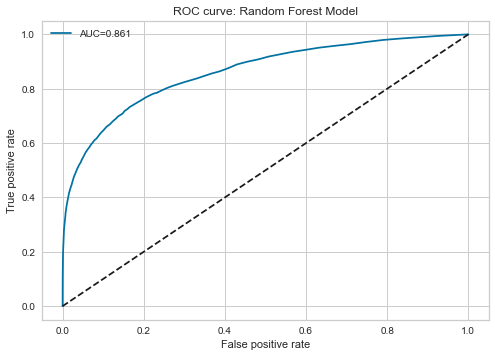

In [ ]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba_rf['y_test_class_actual_rf'], y_test_proba_rf['y_hat_test_proba_rf'])
AUROC_rf = roc_auc_score(y_test_proba_rf['y_test_class_actual_rf'], y_test_proba_rf['y_hat_test_proba_rf'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, to plot randomness of model
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(["AUC=%.3f"%AUROC_rf])
plt.title('ROC curve: Random Forest Model');

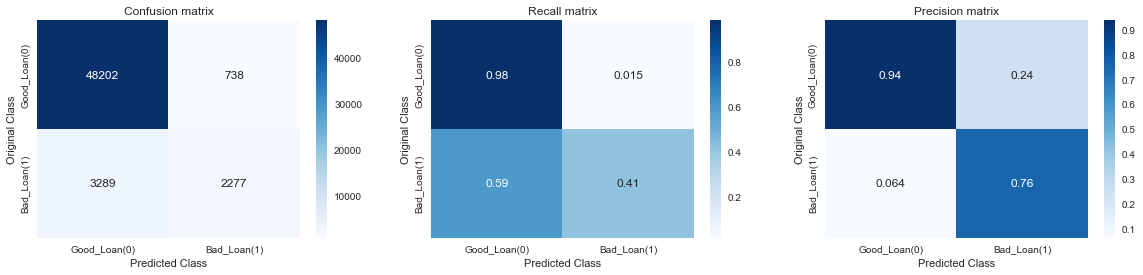

In [ ]:
plot_confusion_matrix(y_test, y_pred_rf)

AdaBoost

In [ ]:
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print(classification_report(y_pred_ada, y_test))
print(confusion_matrix(y_pred_ada, y_test))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85     38108
           1       0.78      0.26      0.39     16398

    accuracy                           0.76     54506
   macro avg       0.76      0.62      0.62     54506
weighted avg       0.76      0.76      0.71     54506

[[36864  1244]
 [12076  4322]]


In [ ]:
y_hat_test_proba_ada = ada.predict_proba(X_test)
y_hat_test_proba_ada = y_hat_test_proba_ada[:][: , 1]
y_test_temp_ada = y_test.copy()
y_test_temp_ada.reset_index(drop = True, inplace = True)
y_test_proba_ada = pd.concat([y_test_temp_ada, pd.DataFrame(y_hat_test_proba_ada), pd.DataFrame(y_pred_ada)], axis = 1)
y_test_proba_ada.columns = ['y_test_class_actual_ada', 'y_hat_test_proba_ada', 'y_hat_test_ada']
y_test_proba_ada.index = X_test.index
y_test_proba_ada.head()

,y_test_class_actual_ada,y_hat_test_proba_ada,y_hat_test_ada
19526,0,0.493727,0
51480,1,0.500117,1
50371,0,0.500305,1
85705,0,0.497105,0
11738,0,0.498019,0


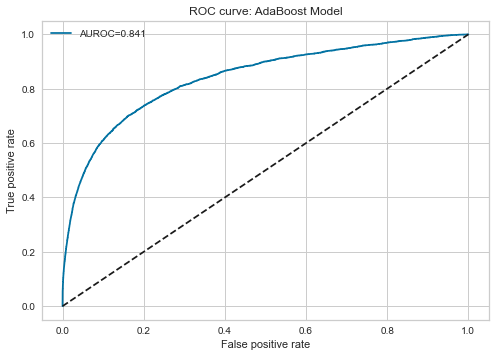

In [ ]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba_ada['y_test_class_actual_ada'], y_test_proba_ada['y_hat_test_proba_ada'])
AUROC_ada = roc_auc_score(y_test_proba_ada['y_test_class_actual_ada'], y_test_proba_ada['y_hat_test_proba_ada'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, to plot randomness of model
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(["AUROC=%.3f"%AUROC_ada])
plt.title('ROC curve: AdaBoost Model');

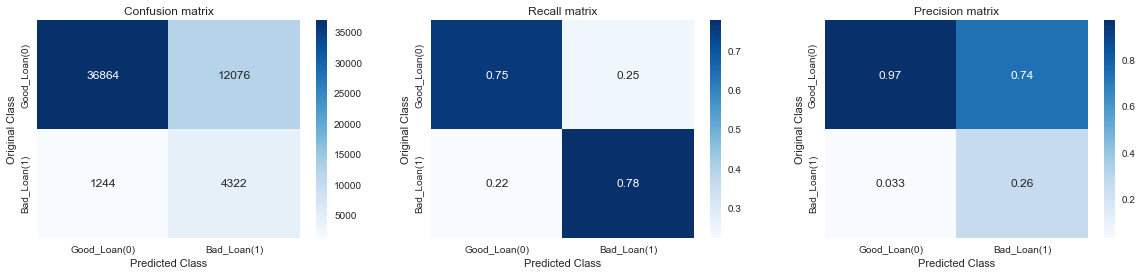

In [ ]:
plot_confusion_matrix(y_test, y_pred_ada)

GradientBoost

In [ ]:
gb = GradientBoostingClassifier(learning_rate = 0.5, n_estimators = 300, max_depth = 3, max_features = 'auto', random_state=42)
gb.fit(X_train, y_train)
y_pred_gb= gb.predict(X_test)
print(classification_report(y_pred_gb, y_test))
print(confusion_matrix(y_pred_gb, y_test))
print('The percentage of misclassified points = {:05.2f}%'.format((1-accuracy_score(y_test, y_pred_gb))*100))

c:\Users\cynti\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\cynti\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\cynti\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\cynti\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\cynti\a

              precision    recall  f1-score   support

           0       0.83      0.97      0.89     41771
           1       0.77      0.33      0.47     12735

    accuracy                           0.82     54506
   macro avg       0.80      0.65      0.68     54506
weighted avg       0.81      0.82      0.79     54506

[[40467  1304]
 [ 8473  4262]]
The percentage of misclassified points = 17.94%


In [ ]:
y_hat_test_proba_gb = gb.predict_proba(X_test)
y_hat_test_proba_gb = y_hat_test_proba_gb[:][: , 1]
y_test_temp_gb = y_test.copy()
y_test_temp_gb.reset_index(drop = True, inplace = True)
y_test_proba_gb = pd.concat([y_test_temp_gb, pd.DataFrame(y_hat_test_proba_gb), pd.DataFrame(y_pred_gb)], axis = 1)
y_test_proba_gb.columns = ['y_test_class_actual_gb', 'y_hat_test_proba_gb', 'y_hat_test_gb']
y_test_proba_gb.index = X_test.index
y_test_proba_gb.head()

,y_test_class_actual_gb,y_hat_test_proba_gb,y_hat_test_gb
19526,0,0.146426,0
51480,1,0.431036,0
50371,0,0.484306,0
85705,0,0.303474,0
11738,0,0.171043,0


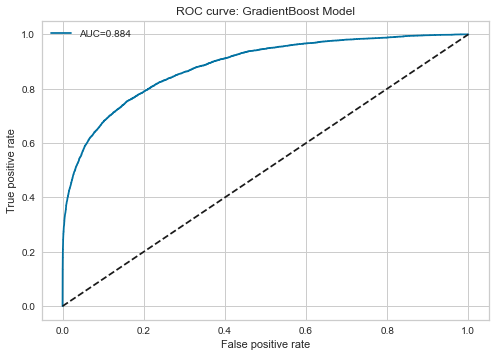

In [ ]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba_gb['y_test_class_actual_gb'], y_test_proba_gb['y_hat_test_proba_gb'])
AUROC_gb = roc_auc_score(y_test_proba_gb['y_test_class_actual_gb'], y_test_proba_gb['y_hat_test_proba_gb'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, to plot randomness of model
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(["AUC=%.3f"%AUROC_gb])
plt.title('ROC curve: GradientBoost Model');

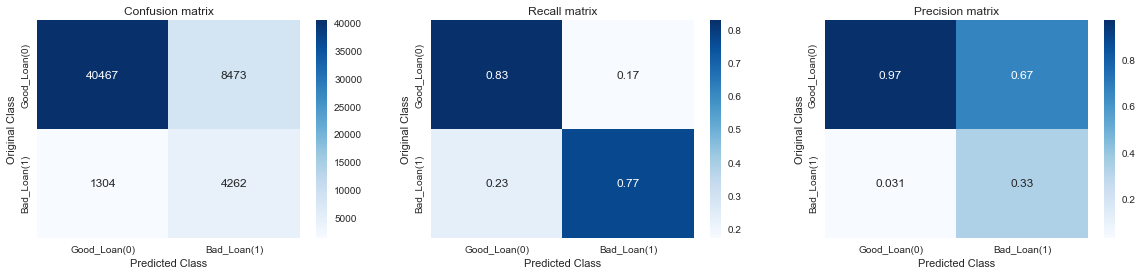

In [ ]:
plot_confusion_matrix(y_test, y_pred_gb)

Therefore, the model we pick is Logistic Regression model because it has the highest recall score out of all the models.